In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

gpu = torch.device('cuda')
cpu = torch.device('cpu')

In [2]:
#data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
data = pd.read_json('../input/annamayya-song-lyrical-map/song_lyric_map.json')
data['iGenre'] = data.apply(lambda x:int(x.Genre=='Devotional'),axis=1)

In [3]:
def build_word_tokenizer(sentences, word_threshold=1):
    word_sequences = [[] for _ in sentences]
    # Dictionary to create word to frequency
    word_counter = Counter()
    for i, sentence in enumerate(sentences):
        for word in sentence.split():
            word_counter.update([word])
            word_sequences[i].append(word)
    word_counter = {k: v for k, v in word_counter.items() if v > word_threshold}
    word_counter = sorted(word_counter, key=word_counter.get, reverse=True)
    word2idx = defaultdict(int)
    idx2word = defaultdict(str)
    for i, word in enumerate(word_counter):
        word2idx[word] = i
        idx2word[i] = word
    return word_counter, word_sequences, word2idx, idx2word


def pad_input(sent_sequence, seq_len):
    features = np.zeros((len(sent_sequence), seq_len), dtype=int)
    for i, sentence in enumerate(sent_sequence):
        if len(sentence) != 0:
            features[i, -len(sentence):] = np.array(sentence)[:seq_len]
    return features


def tokenize(sentences, word2idx, seq_len=None):
    token_matrix = [[] for _ in sentences]
    for i, sentence in enumerate(sentences):
        token_matrix[i] = [word2idx[word] for word in sentence.split()]
    if seq_len:
      token_matrix = pad_input(token_matrix, seq_len)
    return token_matrix

In [4]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Validation']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.title(title)
        plt.legend(legend_labels)
        if not loss: 
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))
    
    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [5]:
# Ref : https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/ 
class LstmModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, seq_len, fusion=False, n_layers=6, drop_prob=0.1):
        super(LstmModel, self).__init__()
        self.n_layers = 6
        self.hidden_dim = hidden_dim
        self.fusion = fusion
        self.seq_len = seq_len
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, self.n_layers, dropout=drop_prob, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(drop_prob)
        if self.fusion:
            self.fc = nn.Linear(2*hidden_dim, 512)
            self.fca = [nn.Linear(41,64), nn.ReLU(), nn.Linear(64,128), nn.ReLU()]
            self.fusion = [nn.Linear(128+512,512), nn.ReLU(), nn.Linear(512, 2), nn.ReLU()] # 128 + 512
        else:
            self.fc = nn.Linear(2*hidden_dim, 2)
        self.softmax = nn.LogSoftmax(dim=0)
        
    def forward(self, x, mfcc, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        out_forward = lstm_out[range(len(lstm_out)), self.seq_len - 1, :self.hidden_dim]
        out_reverse = lstm_out[:, 0, self.hidden_dim:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.dropout(out_reduced)
        out = self.fc(out)
        out = torch.relu_(out)
        if self.fusion:
            a = mfcc
            for layer in self.fca:
                layer.to(gpu)
                a = layer(a)
            
            out = torch.cat((out,a), dim=1)
            for layer in self.fusion:
                layer.to(gpu)
                out = layer(out)            
        out = self.softmax(out)
        out = out.view(batch_size, -1)
        return out, hidden
    
    def init_hidden(self, batch_size, target_device):
        weight = next(self.parameters()).data
        hidden = (weight.new(2*self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device),
                      weight.new(2*self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device))
        return hidden

In [6]:
def run_model(model, data_loader, loss_fcn, optimizer, target_device, is_training, clip_at=10):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy = 0, 0
    # empty list to save model predictions
    model_predictions, model_labels = [], []
    # iterate over batches
    for step, batch in enumerate(data_loader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(data_loader)))
        # push the batch to gpu
        batch = [r.to(target_device) for r in batch]
        sent_vectors, mfcc_means, labels = batch
        h = model.init_hidden(len(labels), target_device)
        if is_training:
            model.zero_grad()  # clear previously calculated gradients
            # get model predictions for the current batch
            predictions, tmp1 = model(sent_vectors, mfcc_means, h)
            del tmp1
        else:
            with torch.no_grad(): 
                predictions, tmp1 = model(sent_vectors, mfcc_means, h)
                del tmp1        
        loss = loss_fcn(predictions, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            optimizer.step()
        predictions = predictions.detach().cpu().numpy()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(data_loader)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels, model, optimizer

In [7]:
def model_execution(fusion):
    torch.manual_seed(42)
    
    X_train, X_test, y_train, y_test = train_test_split(data[['Lyric','mfcc_mean']],data['iGenre'],random_state=42, test_size=0.3)
    word_counter, word_sequences, word2idx, idx2word = build_word_tokenizer(X_train['Lyric'], 5)
    
    vocab_size = len(word2idx) + 1
    embedding_dim = 256
    hidden_dim = 128
    lr = 5e-5
    results = {x: {} for x in range(1)}
    fold = 0
    batch_size = 16
    epochs = 15

    
    best_valid_loss = float('inf')    
    best_train_predictions, best_test_predictions, best_train_labels, best_test_labels = [], [], [], []
    results[fold]['train_precision'] = []
    results[fold]['train_recall'] = []
    results[fold]['train_f1'] = []
    results[fold]['validation_precision'] = []
    results[fold]['validation_recall'] = []
    results[fold]['validation_f1'] = []
    train_losses, valid_losses = [], []

    seq_len = 300
    train_tokens = tokenize(X_train['Lyric'], word2idx, seq_len=seq_len)
    test_tokens = tokenize(X_test['Lyric'], word2idx, seq_len=seq_len)
    
    train_mfcc = torch.tensor([[_ for _ in x] for x in X_train['mfcc_mean']])
    test_mfcc = torch.tensor([[_ for _ in x] for x in X_test['mfcc_mean']])

    train_data = TensorDataset(torch.from_numpy(train_tokens), train_mfcc, torch.from_numpy(y_train.to_numpy()))
    test_data = TensorDataset(torch.from_numpy(test_tokens), test_mfcc, torch.from_numpy(y_test.to_numpy()))

    train_data_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_data_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
    
    loss_fcn = nn.NLLLoss()
    model = LstmModel(vocab_size, embedding_dim, hidden_dim, seq_len, fusion)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(gpu)
    
    for epoch in range(epochs):
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
        # train model
        train_loss, train_predictions, train_labels, model, optimizer = run_model(model, train_data_loader, loss_fcn, optimizer,
                                                                gpu, True)
        # evaluate model
        valid_loss, test_predictions, test_labels, model, optimizer = run_model(model, test_data_loader, loss_fcn, optimizer,
                                                              gpu, False)
        # save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_train_predictions = train_predictions
            best_test_predictions = test_predictions
            best_train_labels = train_labels
            best_test_labels = test_labels
            torch.save(model.state_dict(), f'saved_weights_Fold{fold}.pt')
            # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'Losses - Train:{train_loss:.3f} / Validation:{valid_loss:.3f}')
        results[fold]['train_precision'].append(precision_score(train_labels, train_predictions))
        results[fold]['train_recall'].append(recall_score(train_labels, train_predictions))
        results[fold]['train_f1'].append(f1_score(train_labels, train_predictions))
        results[fold]['validation_precision'].append(precision_score(test_labels, test_predictions))
        results[fold]['validation_recall'].append(recall_score(test_labels, test_predictions))
        results[fold]['validation_f1'].append(f1_score(test_labels, test_predictions))
        torch.cuda.empty_cache()
    print('On Train Data')
    print(classification_report(best_train_labels, best_train_predictions))
    print('On Test Data')
    print(classification_report(best_test_labels, best_test_predictions))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    return results


 Epoch 1 / 15
  Batch    50  of     54.
Losses - Train:2.771 / Validation:2.686

 Epoch 2 / 15
  Batch    50  of     54.
Losses - Train:2.771 / Validation:2.686

 Epoch 3 / 15
  Batch    50  of     54.
Losses - Train:2.771 / Validation:2.686

 Epoch 4 / 15
  Batch    50  of     54.
Losses - Train:2.771 / Validation:2.684

 Epoch 5 / 15
  Batch    50  of     54.
Losses - Train:2.751 / Validation:2.661

 Epoch 6 / 15
  Batch    50  of     54.
Losses - Train:2.729 / Validation:2.682

 Epoch 7 / 15
  Batch    50  of     54.
Losses - Train:2.736 / Validation:2.638

 Epoch 8 / 15
  Batch    50  of     54.
Losses - Train:2.681 / Validation:2.630

 Epoch 9 / 15
  Batch    50  of     54.
Losses - Train:2.666 / Validation:2.626

 Epoch 10 / 15
  Batch    50  of     54.
Losses - Train:2.630 / Validation:2.638

 Epoch 11 / 15
  Batch    50  of     54.
Losses - Train:2.611 / Validation:2.663

 Epoch 12 / 15
  Batch    50  of     54.
Losses - Train:2.589 / Validation:2.646

 Epoch 13 / 15
  Batch  

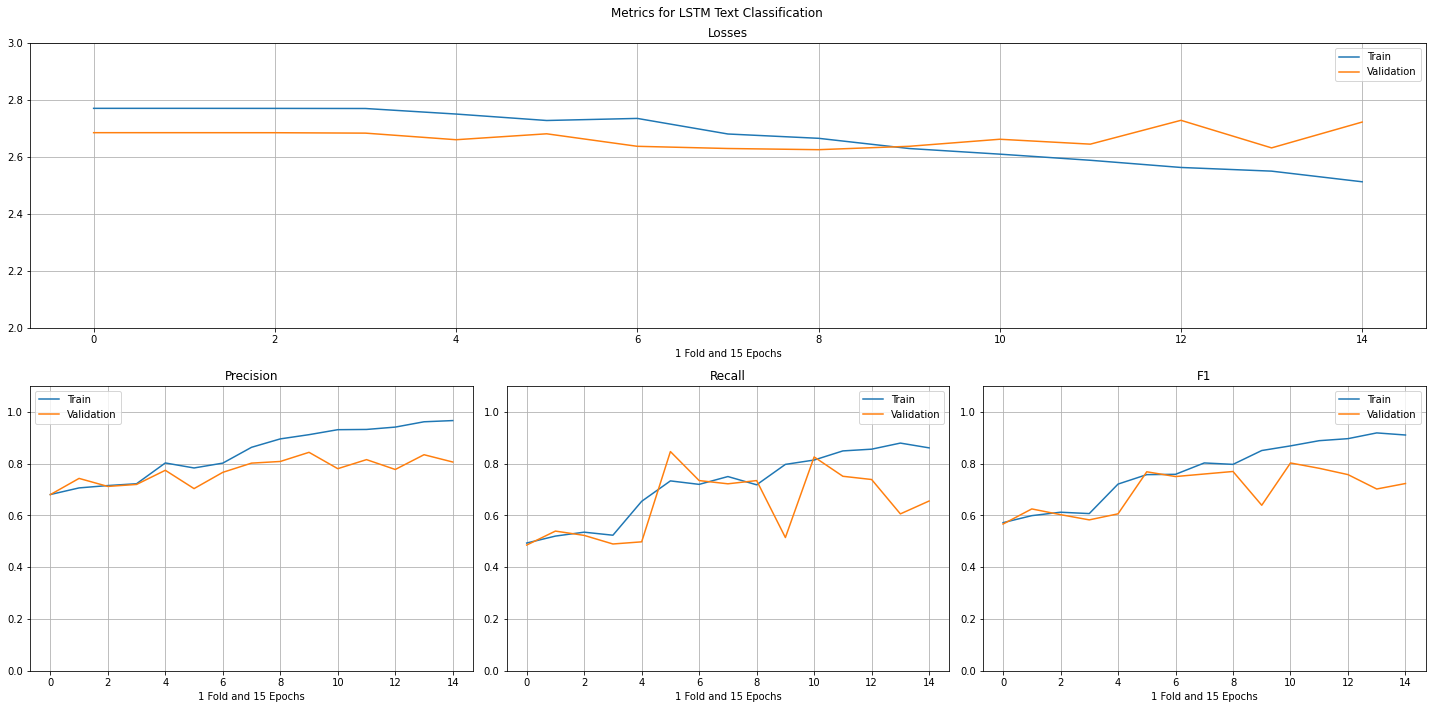

In [8]:
lstm_text_only = model_execution(False)
plot_results(lstm_text_only, 'LSTM Text Classification')


 Epoch 1 / 15
  Batch    50  of     54.
Losses - Train:2.771 / Validation:2.686

 Epoch 2 / 15
  Batch    50  of     54.
Losses - Train:2.771 / Validation:2.686

 Epoch 3 / 15
  Batch    50  of     54.
Losses - Train:2.770 / Validation:2.686

 Epoch 4 / 15
  Batch    50  of     54.
Losses - Train:2.769 / Validation:2.686

 Epoch 5 / 15
  Batch    50  of     54.
Losses - Train:2.767 / Validation:2.685

 Epoch 6 / 15
  Batch    50  of     54.
Losses - Train:2.765 / Validation:2.685

 Epoch 7 / 15
  Batch    50  of     54.
Losses - Train:2.766 / Validation:2.686

 Epoch 8 / 15
  Batch    50  of     54.
Losses - Train:2.765 / Validation:2.681

 Epoch 9 / 15
  Batch    50  of     54.
Losses - Train:2.735 / Validation:2.678

 Epoch 10 / 15
  Batch    50  of     54.
Losses - Train:2.740 / Validation:2.656

 Epoch 11 / 15
  Batch    50  of     54.
Losses - Train:2.662 / Validation:2.632

 Epoch 12 / 15
  Batch    50  of     54.
Losses - Train:2.659 / Validation:2.608

 Epoch 13 / 15
  Batch  

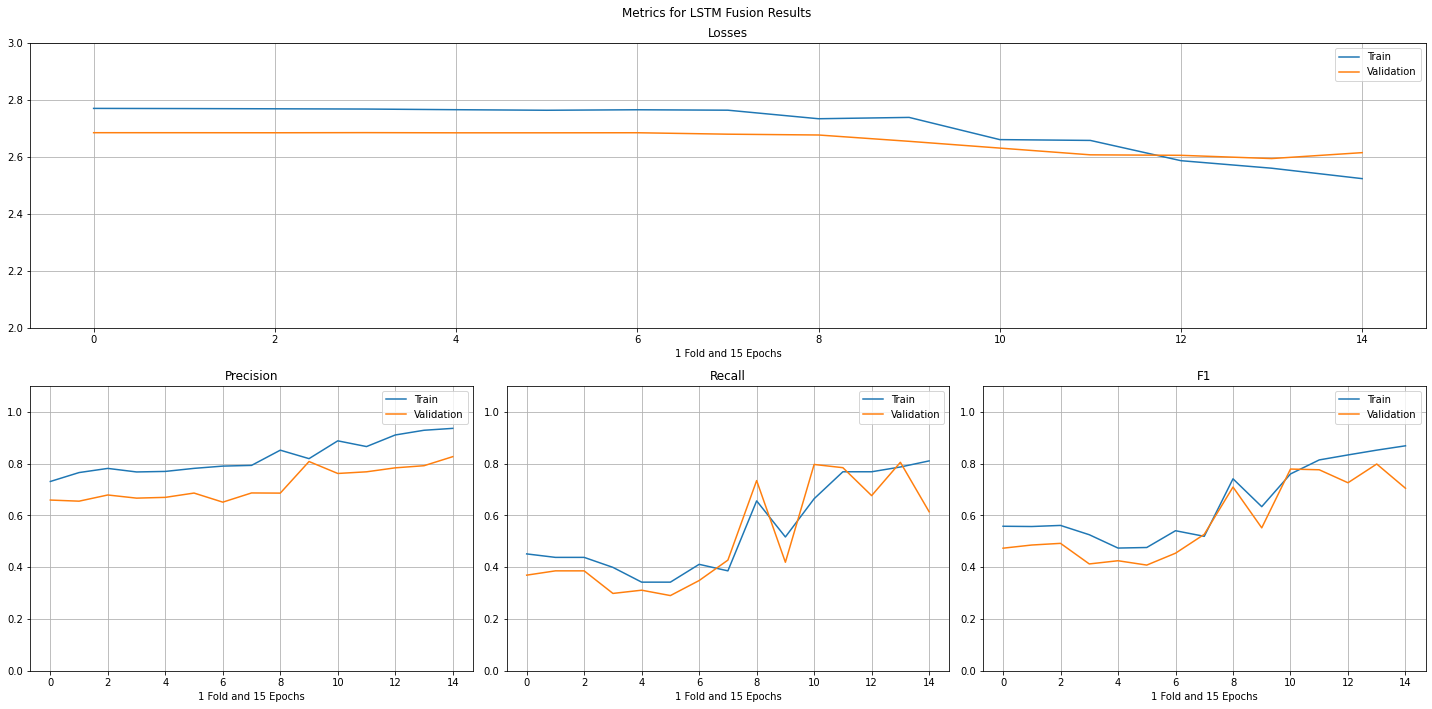

In [9]:
lstm_fusion = model_execution(True)
plot_results(lstm_fusion, 'LSTM Fusion Results')